This python code is used to generate the difference maps of surface soil moisture simulated by GloSea5 and GloSea6

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
from netCDF4 import Dataset, MFDataset
import matplotlib.pyplot as plt
import glob
from datetime import datetime, timedelta
from scipy import stats
from sklearn.metrics import mean_squared_error
import shutil
from scipy.spatial import distance
import metpy

import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

import sys, os, time, warnings
warnings.filterwarnings(action='ignore')
warnings.simplefilter(action='ignore')

In [3]:
import xesmf as xe
var_name = 'sm'

vfile = sorted(glob.glob('/land1/GloSea/G6_HCST/'+var_name+'/*.nc'))
data = xr.open_dataset(vfile[0])
data.coords['longitude'] = (data.coords['longitude'] + 180) % 360 - 180
data = data.sortby(data.longitude)

ds_out = xr.Dataset({"lat": (["lat"], data.latitude.values), "lon": (["lon"], data.longitude.values), })

In [4]:
ens_g5 = 3
syear_g5 = 1993
eyear_g5 = 2016
season_g5 = "MJJA"

if season_g5 == "JJA":
    mons = [x for x in range(6,9)]
elif season_g5 == "DJF":
    mons = [1,2,12]
elif season_g5 == "MAM":
    mons = [x for x in range(3,6)]
elif season_g5 == "SON":
    mons = [x for x in range(9,12)]
elif season_g5 == "MJJAS":
    mons = [x for x in range(5,10)]
elif season_g5 == "MJJA":
    mons = [x for x in range(5,9)]
    
years = [x for x in range(syear_g5,eyear_g5+1)]
days = ['01', '09', '17', '25']
init_dates_g5 = [None] * len(years) * len(mons) * len(days)

cnt = 0
for yr in years:
    for im in mons:
        for id in days:
            # if yr == 2011 and im<=3:
            #     init_dates[cnt] = ''
            # elif yr == 2018 and im>=4:
            #     init_dates[cnt] = ''
            # else:
            #     init_dates[cnt] = '{}{:02d}{}'.format(yr,im,id)
            init_dates_g5[cnt] = '{}{:02d}{}'.format(yr,im,id)
            cnt = cnt + 1

init_dates_g5 = list(filter(None, init_dates_g5))
# print(init_dates_g5)
comp = dict(zlib=True, complevel=1)

In [5]:
ens_g6 = 7
syear_g6 = 1993
eyear_g6 = 2016
season_g6 = "MJJA"

if season_g6 == "JJA":
    mons = [x for x in range(6,9)]
elif season_g6 == "DJF":
    mons = [1,2,12]
elif season_g6 == "MAM":
    mons = [x for x in range(3,6)]
elif season_g6 == "SON":
    mons = [x for x in range(9,12)]
elif season_g6 == "MJJAS":
    mons = [x for x in range(5,10)]
elif season_g6 == "MJJA":
    mons = [x for x in range(5,9)]
    
years = [x for x in range(syear_g6,eyear_g6+1)]
days = ['01', '09', '17', '25']
init_dates_g6 = [None] * len(years) * len(mons) * len(days)

cnt = 0
for yr in years:
    for im in mons:
        for id in days:
            # if yr == 2011 and im<=3:
            #     init_dates[cnt] = ''
            # elif yr == 2018 and im>=4:
            #     init_dates[cnt] = ''
            # else:
            #     init_dates[cnt] = '{}{:02d}{}'.format(yr,im,id)
            init_dates_g6[cnt] = '{}{:02d}{}'.format(yr,im,id)
            cnt = cnt + 1

init_dates_g6 = list(filter(None, init_dates_g6))
# print(init_dates_g6)
comp = dict(zlib=True, complevel=1)

In [8]:
var_name = 'sm'
var_name1 = 'swvl1'
var_name2 = 'sm'

dir='/land1/GloSea/G5_HCST/'
nlead = 2

ens_g5 = 3
syear_g5 = 1993
eyear_g5 = 2016
season_g5 = "MJJA"

if season_g5 == "JJA":
    mons = [x for x in range(6,9)]
elif season_g5 == "DJF":
    mons = [1,2,12]
elif season_g5 == "MAM":
    mons = [x for x in range(3,6)]
elif season_g5 == "SON":
    mons = [x for x in range(9,12)]
elif season_g5 == "MJJAS":
    mons = [x for x in range(5,10)]
elif season_g5 == "MJJA":
    mons = [x for x in range(5,9)]
    
years = [x for x in range(syear_g5,eyear_g5+1)]
days = ['01', '09', '17', '25']
init_dates = [None] * len(mons) * len(days)

cnt = 0
for im in mons:
    for id in days:
        init_dates[cnt] = '{:02d}{}'.format(im,id)
        cnt = cnt + 1
        


mod_g5 = xr.DataArray(data = np.empty([len(years),len(init_dates),ens_g5,nlead,len(ds_out.lat),len(ds_out.lon)]) * np.nan, 
                       dims=["years","init_dates","ensembles","leads","lat","lon"],
                       coords = dict(years=(["years"], years),
                                     init_dates=(["init_dates"], init_dates),
                                     ensembles=(["ensembles"], [x for x in range(ens_g5)]),
                                     leads=(["leads"], [x for x in range(nlead)]),
                                     lat=(["lat"], ds_out.lat.values),
                                     lon=(["lon"], ds_out.lon.values),
                                    )
                      )
obs = xr.DataArray(data = np.empty([len(years),len(init_dates),nlead,len(ds_out.lat),len(ds_out.lon)]) * np.nan, 
                   dims=["years","init_dates","leads","lat","lon"],
                   coords = dict(years=(["years"], years),
                                 init_dates=(["init_dates"], init_dates),
                                 leads=(["leads"], [x for x in range(nlead)]),
                                 lat=(["lat"], ds_out.lat.values),
                                 lon=(["lon"], ds_out.lon.values),
                                )
                  )

for y,yr in enumerate(years):
    print(yr)
    vfile = sorted(glob.glob('/land1/ERA5/hourly/land/'+str(yr)+'*_land.nc'))
    ind = [i for i, s in enumerate(vfile) if '05_land' in s][0]
    data1 = xr.open_mfdataset(vfile[ind:ind+6], concat_dim='time', combine='nested')[var_name1]
    data1.coords['longitude'] = (data1.coords['longitude'] + 180) % 360 - 180
    data1 = data1.sortby(data1.longitude)
    data1 = data1.rename({'longitude': 'lon', 'latitude': 'lat'})
    data1 = data1.reindex(lat=data1.lat[::-1])
    data2 = data1.resample(time='1D',base=0,keep_attrs=True).mean(keep_attrs=True)
    del data1, vfile, ind
    regridder = xe.Regridder(data2, ds_out, "bilinear")
    obs_rgd = regridder(data2)
    del data2
    
    for i,id in enumerate(init_dates):
        # print(yr,id)
        vfile = sorted(glob.glob(dir+var_name+'/'+str(yr)+id+'*.nc'))
        data1 = xr.open_mfdataset(vfile, concat_dim='ens', combine='nested')[var_name2].isel(level6=0)
        data1.coords['longitude'] = (data1.coords['longitude'] + 180) % 360 - 180
        data1 = data1.sortby(data1.longitude)
        data1 = data1.rename({'t': 'time', 'longitude': 'lon', 'latitude': 'lat'})
        # data2 = data1.resample(time='1D',base=0,keep_attrs=True).mean(keep_attrs=True)
        data2 = data1
        del data1
        # sys.exit()
        init_date = pd.to_datetime(str(yr)+id, format='%Y%m%d')
        time_day = pd.date_range(start=init_date, periods=len(data2.time), freq='D')
        
        mod_g5[y,i,:len(data2.ens),0,:,:] = data2.sel(time=slice(time_day[0],time_day[29])).mean(dim='time').values
        mod_g5[y,i,:len(data2.ens),1,:,:] = data2.sel(time=slice(time_day[30],time_day[59])).mean(dim='time').values
        
        
        obs[y,i,0,:,:] = obs_rgd.sel(time=slice(time_day[0],time_day[29])).mean(dim='time').values
        obs[y,i,1,:,:] = obs_rgd.sel(time=slice(time_day[30],time_day[59])).mean(dim='time').values
        
        del data2
        del init_date
        del time_day
                
       
    del obs_rgd
        

1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016


In [7]:
var_name = 'sm'
var_name2 = 'sm'
dir='/land1/GloSea/G6_HCST/'
nlead = 2

ens_g6 = 7
syear_g6 = 1993
eyear_g6 = 2016
season_g6 = "MJJA"

if season_g6 == "JJA":
    mons = [x for x in range(6,9)]
elif season_g6 == "DJF":
    mons = [1,2,12]
elif season_g6 == "MAM":
    mons = [x for x in range(3,6)]
elif season_g6 == "SON":
    mons = [x for x in range(9,12)]
elif season_g6 == "MJJAS":
    mons = [x for x in range(5,10)]
elif season_g6 == "MJJA":
    mons = [x for x in range(5,9)]
    
years = [x for x in range(syear_g6,eyear_g6+1)]
days = ['01', '09', '17', '25']
init_dates = [None] * len(mons) * len(days)

cnt = 0
for im in mons:
    for id in days:
        init_dates[cnt] = '{:02d}{}'.format(im,id)
        cnt = cnt + 1
        


mod_g6 = xr.DataArray(data = np.empty([len(years),len(init_dates),ens_g6,nlead,len(ds_out.lat),len(ds_out.lon)]) * np.nan, 
                       dims=["years","init_dates","ensembles","leads","lat","lon"],
                       coords = dict(years=(["years"], years),
                                     init_dates=(["init_dates"], init_dates),
                                     ensembles=(["ensembles"], [x for x in range(ens_g6)]),
                                     leads=(["leads"], [x for x in range(nlead)]),
                                     lat=(["lat"], ds_out.lat.values),
                                     lon=(["lon"], ds_out.lon.values),
                                    )
                      )

for y,yr in enumerate(years):
    print(yr)
    for i,id in enumerate(init_dates):
        # print(yr,id)
        vfile = sorted(glob.glob(dir+var_name+'/'+str(yr)+id+'*.nc'))
        data1 = xr.open_mfdataset(vfile, concat_dim='ens', combine='nested')[var_name2].isel(level6=0)
        data1.coords['longitude'] = (data1.coords['longitude'] + 180) % 360 - 180
        data1 = data1.sortby(data1.longitude)
        data1 = data1.rename({'t': 'time', 'longitude': 'lon', 'latitude': 'lat'})
        # data2 = data1.resample(time='1D',base=0,keep_attrs=True).max(keep_attrs=True)
        data2 = data1
        del data1
        
        init_date = pd.to_datetime(str(yr)+id, format='%Y%m%d')
        time_day = pd.date_range(start=init_date, periods=len(data2.time), freq='D')
        
        mod_g6[y,i,:len(data2.ens),0,:,:] = data2.sel(time=slice(time_day[0],time_day[29])).mean(dim='time').values
        mod_g6[y,i,:len(data2.ens),1,:,:] = data2.sel(time=slice(time_day[30],time_day[59])).mean(dim='time').values
        
        del data2
        del init_date
        del time_day
        

1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016


In [ ]:
def cal_rmse(a, b, dim):
    """
    Parameters
    ----------
    a : xarray
        source variable
    b : xarray
        target variable
    dim : string
        dimension along which to compute test
    
    Returns
    -------
    RMSE : xarray
        calculated RMSE
    """
    diff = ( b - a ) ** 2
    return ( diff.mean(dim) ) ** 0.5

def cal_bias(a, b, dim):
    """
    Parameters
    ----------
    a : xarray
        source variable
    b : xarray
        target variable
    dim : string
        dimension along which to compute test
    
    Returns
    -------
    RMSE : xarray
        calculated RMSE
    """
    diff = b - a
    return diff.mean(dim)

def area_avg_weight(a, lon_str, lat_str):
    weights = np.cos(np.deg2rad(a.lat))
    weights.name = "weights"
    a_weighted = a.weighted(weights)
    weighted_mean = a_weighted.mean(("lon", "lat"))
    return weighted_mean.values.item()

country_borders = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_0_boundary_lines_land',
    scale='50m',
    facecolor='none')

corr_g5 = xr.corr(obs, mod_g5.mean(dim='ensembles')/ 100., 'years')
corr_g6 = xr.corr(obs, mod_g6.mean(dim='ensembles')/ 100., 'years')

rmse_g5 = cal_rmse(obs, mod_g5.mean(dim='ensembles')/ 100., 'years')
rmse_g6 = cal_rmse(obs, mod_g6.mean(dim='ensembles')/ 100., 'years')

bias_g5 = cal_bias(obs, mod_g5.mean(dim='ensembles')/ 100., 'years')
bias_g6 = cal_bias(obs, mod_g6.mean(dim='ensembles')/ 100., 'years')

In [18]:
corr_sig_diff = xr.DataArray(data = np.empty([nlead,len(ds_out.lat),len(ds_out.lon)]) * np.nan, 
                             dims=["leads","lat","lon"],
                             coords = dict(leads=(["leads"], [x for x in range(nlead)]),
                                           lat=(["lat"], ds_out.lat.values),
                                           lon=(["lon"], ds_out.lon.values),
                                          )
                            )

rmse_sig_diff = corr_sig_diff.copy(deep=True)
bias_sig_diff = corr_sig_diff.copy(deep=True)


bias_sig_g5 = corr_sig_diff.copy(deep=True)
bias_sig_g6 = corr_sig_diff.copy(deep=True)

corr_sig_diff[:] = stats.ttest_ind( corr_g5, corr_g6, axis=0, equal_var=False ).pvalue
rmse_sig_diff[:] = stats.ttest_ind( rmse_g5, rmse_g6, axis=0, equal_var=False ).pvalue
bias_sig_diff[:] = stats.ttest_ind( bias_g5, bias_g6, axis=0, equal_var=False ).pvalue

bias_sig_g5[:] = stats.ttest_ind( obs.stack(samp=("years", "init_dates")), mod_g5.stack(samp=("years", "init_dates", "ensembles"))/ 100., axis=3, equal_var=False ).pvalue
bias_sig_g6[:] = stats.ttest_ind( obs.stack(samp=("years", "init_dates")), mod_g6.stack(samp=("years", "init_dates", "ensembles"))/ 100., axis=3, equal_var=False ).pvalue


In [8]:
nrows = 3
ncols = 1

plot_maps = xr.DataArray(data = np.empty([nrows*ncols,len(ds_out.lat),len(ds_out.lon)]) * np.nan, 
                    dims=["maps","lat","lon"],
                    coords = dict(maps=(["maps"], [x for x in range(nrows*ncols)]),
                                  lat=(["lat"], ds_out.lat.values),
                                  lon=(["lon"], ds_out.lon.values),
                                 )
                   )
plot_sig = plot_maps.copy(deep=True)


plot_maps[0,:,:] = ( mod_g6.isel(leads=0).mean(dim=('years','init_dates','ensembles')) - mod_g5.isel(leads=0).mean(dim=('years','init_dates','ensembles')) ) / 100.
plot_maps[1,:,:] = ( mod_g6.isel(leads=1).mean(dim=('years','init_dates','ensembles')) - mod_g5.isel(leads=1).mean(dim=('years','init_dates','ensembles')) ) / 100.
plot_maps[2,:,:] = ( mod_g6.mean(dim=('years','init_dates','ensembles','leads')) - mod_g5.mean(dim=('years','init_dates','ensembles','leads')) ) / 100.

plot_sig[0,:,:] = stats.ttest_ind( mod_g6.isel(leads=0).stack(samp=('years','init_dates','ensembles')), mod_g5.isel(leads=0).stack(samp=('years','init_dates','ensembles')), axis=2, equal_var=False ).pvalue
plot_sig[1,:,:] = stats.ttest_ind( mod_g6.isel(leads=1).stack(samp=('years','init_dates','ensembles')), mod_g5.isel(leads=1).stack(samp=('years','init_dates','ensembles')), axis=2, equal_var=False ).pvalue
plot_sig[2,:,:] = stats.ttest_ind( mod_g6.stack(samp=('years','init_dates','ensembles','leads')), mod_g5.stack(samp=('years','init_dates','ensembles','leads')), axis=2, equal_var=False ).pvalue

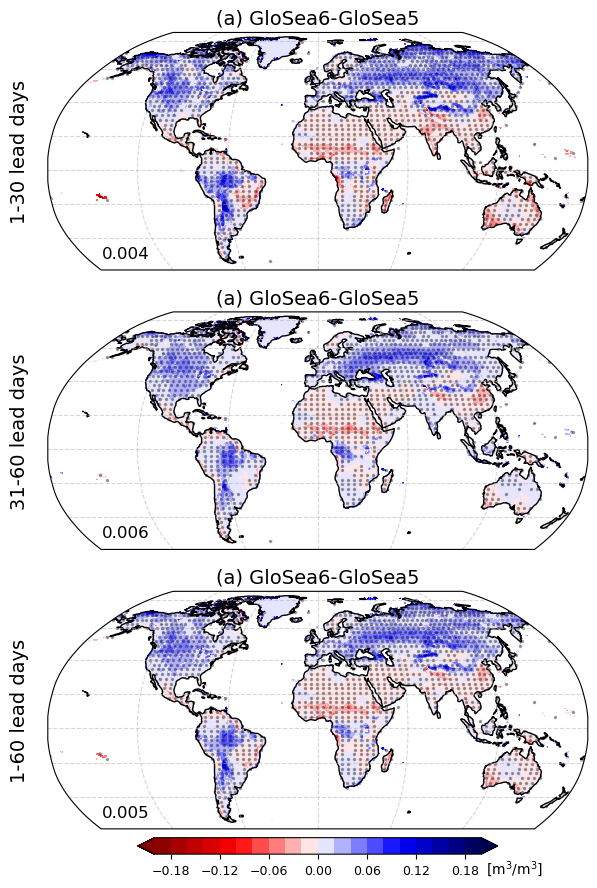

In [22]:
import string
alphabet = list(string.ascii_lowercase)

map_name = 'diff'

nrows = 3
ncols = 1
var_names = ['1-30 lead days','31-60 lead days','1-60 lead days']
titles = ['(a) GloSea6-GloSea5','(a) GloSea6-GloSea5','(a) GloSea6-GloSea5']

fname='./fig/'+var_name+'_'+map_name+'_maps_MJJA_ERA5.png'
  
# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,
                        subplot_kw={'projection': ccrs.Robinson(central_longitude=0)},
                        figsize=(6,11))

# axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
axs=axs.flatten()

    
for pp in range(nrows*ncols):
    
    axs[pp].set_global()
    
    data = plot_maps.isel(maps=pp).sel(lat=slice(-60,90))
    data3 = plot_sig.isel(maps=pp).sel(lat=slice(-60,90))
    dint=5
    cmaps = 'seismic_r'
    clevs = np.arange(-0.2,0.22,0.02)

    axs[pp].set_extent([data.lon.values.min(), data.lon.values.max(), data.lat.values.min(), data.lat.values.max()])
    lon2d, lat2d = np.meshgrid(data.lon, data.lat)
    
    cs = axs[pp].contourf(lon2d,lat2d,data,clevs,
                      transform = ccrs.PlateCarree(),
                      cmap=cmaps,extend='both')
    
    
    lon_sig = data.copy()
    lon_sig = lon_sig.where(False, lon2d)
    lon_sig = lon_sig.where(data3<0.05, np.nan)
    lat_sig = data.copy()
    lat_sig = lat_sig.where(False, lat2d)
    lat_sig = lat_sig.where(data3<0.05, np.nan)
    axs[pp].plot(lon_sig[::dint,::dint], lat_sig[::dint,::dint],'.',transform = ccrs.PlateCarree(),color='black',markersize=3, alpha=0.3)
    
    # Title each subplot with the name of the model
    # if pp//ncols == 0:
    #     axs[pp].set_title(titles[pp], fontsize=14)
    axs[pp].set_title(titles[pp], fontsize=14)
        
    # Draw the coastines for each subplot
    axs[pp].coastlines()
    
    # Draw the grid-lines for each subplot
    # axs[pp].gridlines()
    
    aave = area_avg_weight(data, 'lon', 'lat')
    axs[pp].annotate('{}'.format(round(aave,3)),xy=(0.1, 0.07), xycoords='axes fraction',
                     horizontalalignment='left', verticalalignment='center', color='black', fontsize=12)
    
    # axs[pp].annotate('{}'.format(titles[pp]),xy=(0.5, 0.07), xycoords='axes fraction',
    #                  horizontalalignment='center', verticalalignment='center', color='black', fontsize=13)
    
    gl = axs[pp].gridlines(crs=ccrs.PlateCarree(), draw_labels=False, alpha=0.5, linestyle='--')
    gl.xlabel_style = {'size': 8, 'color': 'gray', 'weight': 'bold'}
    gl.ylabel_style = {'size': 8, 'color': 'gray', 'weight': 'bold'}
        

        
for pp in range(nrows*ncols):
    if pp%ncols == 0:
        axs[pp].text(-0.07,0.5, var_names[pp//ncols], size=14, rotation=90, verticalalignment="center", transform=axs[pp].transAxes)
        
# Delete the unwanted axes
# for i in [7,8]:
#     fig.delaxes(axs[i])

# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.15, top=0.9, left=0.05, right=0.95,
                    wspace=0.05, hspace=0.05)

# Add a colorbar axis at the bottom of the graph
cbar_ax  = fig.add_axes([0.2, 0.14, 0.6, 0.015])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal')
cbar.ax.tick_params(labelsize=9)

fig.text(0.78,0.123, '[{}]'.format('m$^3$/m$^3$'), color='black', size=10, rotation=0, horizontalalignment="left")

# Add a big title at the top
plt.savefig(fname, dpi=300, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()


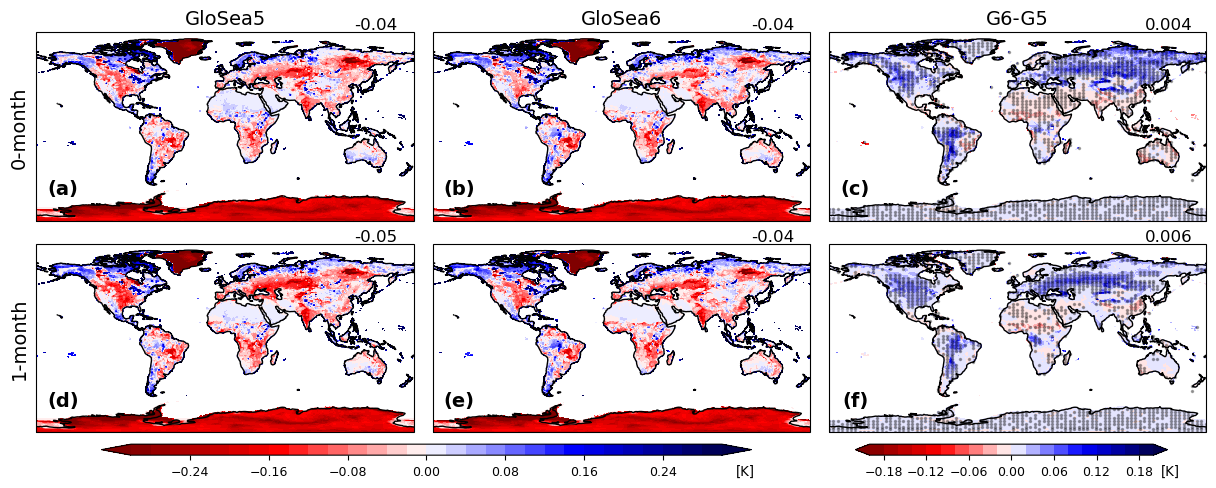

In [ ]:
import string
alphabet = list(string.ascii_lowercase)

map_name = 'bias'

nrows = 2
ncols = 3
var_names = ['0-month','1-month']
titles = ['GloSea5','GloSea6','G6-G5']

fname='./fig/'+var_name+'_'+map_name+'_maps_MJJA_ERA5.png'

plot_maps = xr.DataArray(data = np.empty([nrows*ncols,len(ds_out.lat),len(ds_out.lon)]) * np.nan, 
                    dims=["maps","lat","lon"],
                    coords = dict(maps=(["maps"], [x for x in range(nrows*ncols)]),
                                  lat=(["lat"], ds_out.lat.values),
                                  lon=(["lon"], ds_out.lon.values),
                                 )
                   )
plot_sig = plot_maps.copy(deep=True)


if map_name=='corr':
    plot_maps[0,:,:] = corr_g5.mean(dim='init_dates').isel(leads=0)
    plot_maps[1,:,:] = corr_g6.mean(dim='init_dates').isel(leads=0)
    plot_maps[2,:,:] = plot_maps[1,:,:] - plot_maps[0,:,:]
    plot_maps[3,:,:] = corr_g5.mean(dim='init_dates').isel(leads=1)
    plot_maps[4,:,:] = corr_g6.mean(dim='init_dates').isel(leads=1)
    plot_maps[5,:,:] = plot_maps[4,:,:] - plot_maps[3,:,:]
    plot_sig[2,:,:] = corr_sig_diff.isel(leads=0)
    plot_sig[5,:,:] = corr_sig_diff.isel(leads=1)
    cmaps1 = 'seismic'
    cmaps2 = 'seismic'
    clevs1 = np.arange(-0.8,0.85,0.05)
    clevs2 = np.arange(-0.2,0.22,0.02)
    units = ['-','-']
    des1 = 3
    des2 = 3
    lcol1 = 'black'
    lcol2 = 'black'
elif map_name=='rmse':
    plot_maps[0,:,:] = rmse_g5.mean(dim='init_dates').isel(leads=0)
    plot_maps[1,:,:] = rmse_g6.mean(dim='init_dates').isel(leads=0)
    plot_maps[2,:,:] = plot_maps[1,:,:] - plot_maps[0,:,:]
    plot_maps[3,:,:] = rmse_g5.mean(dim='init_dates').isel(leads=1)
    plot_maps[4,:,:] = rmse_g6.mean(dim='init_dates').isel(leads=1)
    plot_maps[5,:,:] = plot_maps[4,:,:] - plot_maps[3,:,:]
    plot_sig[2,:,:] = rmse_sig_diff.isel(leads=0)
    plot_sig[5,:,:] = rmse_sig_diff.isel(leads=1)
    cmaps1 = 'jet'
    cmaps2 = 'seismic'
    clevs1 = np.arange(0.04,0.84,0.04)
    clevs2 = np.arange(-0.3,0.32,0.02)
    units = ['K','K']
    des1 = 2
    des2 = 3
    lcol1 = 'white'
    lcol2 = 'black'
elif map_name=='bias':
    plot_maps[0,:,:] = bias_g5.mean(dim='init_dates').isel(leads=0)
    plot_maps[1,:,:] = bias_g6.mean(dim='init_dates').isel(leads=0)
    plot_maps[2,:,:] = plot_maps[1,:,:] - plot_maps[0,:,:]
    plot_maps[3,:,:] = bias_g5.mean(dim='init_dates').isel(leads=1)
    plot_maps[4,:,:] = bias_g6.mean(dim='init_dates').isel(leads=1)
    plot_maps[5,:,:] = plot_maps[4,:,:] - plot_maps[3,:,:]
    plot_sig[2,:,:] = bias_sig_diff.isel(leads=0)
    plot_sig[5,:,:] = bias_sig_diff.isel(leads=1)
    cmaps1 = 'seismic_r'
    cmaps2 = 'seismic_r'
    clevs1 = np.arange(-0.3,0.32,0.02)
    clevs2 = np.arange(-0.2,0.22,0.02)
    units = ['K','K']
    des1 = 2
    des2 = 3
    lcol1 = 'black'
    lcol2 = 'black'

# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=nrows,ncols=ncols,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(13,5.5))

# axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
axs=axs.flatten()

#Loop over all of the models
for pp in range(nrows*ncols):
    
    data = plot_maps.isel(maps=pp)
    data3 = plot_sig.isel(maps=pp)
    dint=5
    if pp==2 or pp==5:
        cmaps = cmaps2
        clevs = clevs2
    else:
        cmaps = cmaps1
        clevs = clevs1

    cs=axs[pp].contourf(data['lon'],data['lat'],data,clevs,
                      transform = ccrs.PlateCarree(),
                      cmap=cmaps,extend='both')
    if pp==2 or pp==5:
        cs2 = cs
    else:
        cs1 = cs
    
    # axs[pp].contourf(bias_map.lon,bias_map.lat, sig_map[pp,:,:].where(sig_map[pp,:,:]<=0.01), hatches=["."], alpha=0)
    lon2d2, lat2d2 = np.meshgrid(data.lon,data.lat)
    lon_sig = data.copy()
    lon_sig = lon_sig.where(False, lon2d2)
    lon_sig = lon_sig.where(data3<0.05, np.nan)
    lat_sig = data.copy()
    lat_sig = lat_sig.where(False, lat2d2)
    lat_sig = lat_sig.where(data3<0.05, np.nan)
    axs[pp].plot(lon_sig[::dint,::dint], lat_sig[::dint,::dint],'.',color='black',markersize=3, alpha=0.3)
    
    # Title each subplot with the name of the model
    if pp//ncols == 0:
        axs[pp].set_title(titles[pp], fontsize=14)
        
    # if pp%ncols == 0:
    #     axs[pp].set_ylabel(var_names[pp//ncols])
        
    # Draw the coastines for each subplot
    axs[pp].coastlines()
    
    # Draw the country borders
    # axs[pp].add_feature(country_borders, edgecolor='gray', linestyle='-', linewidth=1)
    
    # Draw the STATES borders
    # axs[pp].cfeature.STATES()
    # Add state boundaries to plot
    # axs[pp].add_feature(cfeature.STATES, edgecolor='gray', linestyle='--', linewidth=0.8, alpha=0.5)
    
    aave = area_avg_weight(data, 'lon', 'lat')
    if pp==2 or pp==5:
        axs[pp].annotate('{}'.format(round(aave,des2)),xy=(0.9, 1.08), xycoords='axes fraction',
                         horizontalalignment='center', verticalalignment='top', color='black', fontsize=12)
    else:
        axs[pp].annotate('{}'.format(round(aave,des1)),xy=(0.9, 1.08), xycoords='axes fraction',
                         horizontalalignment='center', verticalalignment='top', color='black', fontsize=12)
    if pp==2 or pp==5:
        axs[pp].annotate('({})'.format(alphabet[pp]),xy=(0.07, 0.22), xycoords='axes fraction',
                         horizontalalignment='center', verticalalignment='top', color=lcol2, fontsize=14, weight='bold')
    else:
        axs[pp].annotate('({})'.format(alphabet[pp]),xy=(0.07, 0.22), xycoords='axes fraction',
                         horizontalalignment='center', verticalalignment='top', color=lcol1, fontsize=14, weight='bold')
    
    
for pp in range(nrows*ncols):
    if pp%ncols == 0:
        axs[pp].text(-0.07,0.5, var_names[pp//ncols], size=14, rotation=90, verticalalignment="center", transform=axs[pp].transAxes)
    
# Delete the unwanted axes
# for i in [7,8]:
#     fig.delaxes(axs[i])

# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.15, top=0.9, left=0.05, right=0.95,
                    wspace=0.05, hspace=0.05)




# Add a colorbar axis at the bottom of the graph
cbar_ax  = fig.add_axes([0.1, 0.12, 0.5, 0.02])
cbar_ax1 = fig.add_axes([0.68, 0.12, 0.24, 0.02])

# Draw the colorbar
# cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label='[mm/day]')
cbar=fig.colorbar(cs1, cax=cbar_ax,orientation='horizontal')
cbar.set_label('[{}]'.format(units[0]), fontsize=9.5, x=1.04, labelpad=-10)
cbar.ax.tick_params(labelsize=9)

cbar1=fig.colorbar(cs2, cax=cbar_ax1,orientation='horizontal')
cbar1.set_label('[{}]'.format(units[1]), fontsize=9.5, x=1.06, labelpad=-10)
cbar1.ax.tick_params(labelsize=9)

# Add a big title at the top
plt.savefig(fname, dpi=300, bbox_inches = 'tight', pad_inches = 0.02)
plt.show()